# Friends 감정분석 with BERT(Tensorflow)
참고 소스 출처(링크) : 텐서플로2와 머신러닝으로 시작하는 자연어 처리(전창욱 외, 위키북스, 2020)

# 준비
라이브러리, 파라미터 세팅

In [1]:
from transformers import *

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
#from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import re
import json

from nltk.corpus import stopwords
from konlpy.tag import Okt

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

MAX_LEN = 64
BATCH_SIZE = 64
NUM_EPOCHS = 5
TEST_SIZE = 0.2
RANDOM_SEED = 42

# tf.random.set_seed 함수를 이용해 시드를 고정하여 학습 관련 랜덤 변수에 대한 초기 상태를 유지
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 데이터 로드

In [3]:
def jsonToDf(file_name):
    with open(file_name, encoding = 'utf-8', mode = 'r') as file:
        json_array = json.load(file)
  
    result = pd.DataFrame.from_dict(json_array[0])

    is_first = True
    for array in json_array:
        if is_first:
            is_first = False
            continue
    
        temp_df = pd.DataFrame.from_dict(array)
        result = result.append(temp_df, ignore_index = True)

    return result

In [4]:
train_df = jsonToDf(DATA_IN_PATH+'friends_train.json')  # 학습용
dev_df = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 검증용
test_df = pd.read_csv(DATA_IN_PATH+'en_data.csv')  # 테스트(캐글) 데이터

In [5]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(10561, 4)
(1178, 4)
(1623, 5)


# 데이터 탐색(EDA)

(-0.5, 799.5, 599.5, -0.5)

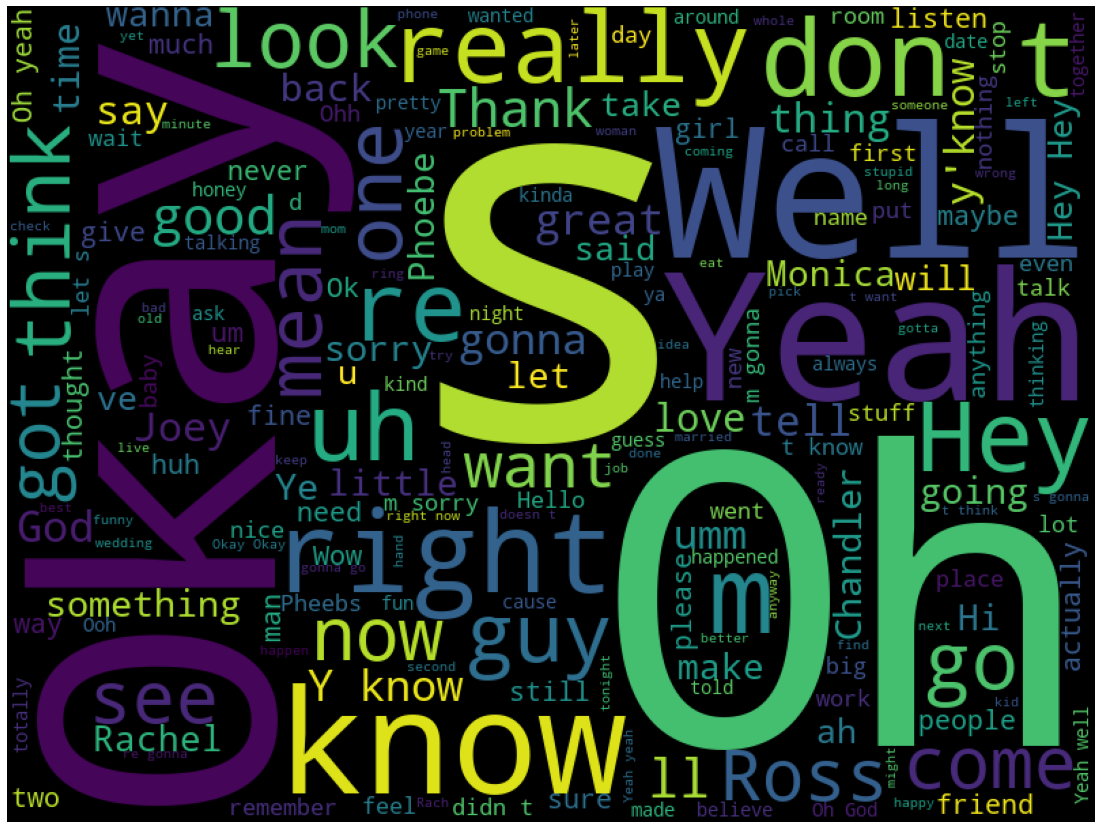

In [6]:
# 워드 클라우드 확인 (많이 사용된 단어)
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_df['utterance']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# (참고) 토크나이저 테스트

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

In [8]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [9]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


In [10]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


# 데이터 전처리

In [11]:
# Bert Tokenizer
# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [12]:
train_df['utterance'] = train_df['utterance'].apply( lambda x : re.sub('[\x92]',"'",str(x)) )
dev_df['utterance'] = dev_df['utterance'].apply( lambda x : re.sub('[\x92]',"'",str(x)) )
test_df['utterance'] = test_df['utterance'].apply( lambda x : re.sub('[\x92]',"'",str(x)) )

In [13]:
# Friends 감정 딕셔너리 생성 (숫자 라벨링 용도)
emoset = {'non-neutral': 0,
          'neutral': 1, 
          'joy': 2,
          'sadness': 3,
          'fear': 4,
          'anger': 5,
          'surprise': 6,
          'disgust': 7}

In [14]:
# 'label' 컬럼 신규
#for emo in train_df['emotion'][:10]:  print(emo, emoset[emo])
train_df['label'] = [emoset[emo] for emo in train_df['emotion']]
dev_df['label'] = [emoset[emo] for emo in dev_df['emotion']]

In [15]:
# train_df = train_df[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_df["utterance"], train_df["label"]), total=len(train_df)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_input_ids), len(train_data_labels)))

  0%|          | 0/10561 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 10561/10561 [00:02<00:00, 5105.88it/s]

# sents: 10561, # labels: 10561


In [16]:
# MAX_LEN ==> 64
input_id = train_input_ids[1]
attention_mask = train_attention_masks[1]
token_type_id = train_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[  101 11065 14982   112 10323 10374 20442 27925 13375   119   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] You must've had your hands full. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

# 모델 생성 & 학습

In [17]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=8)  # 8개 레이블 다중 분류

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [18]:
# 학습 프로세스 설정 (sparse_categorical_crossentropy 기반)
from keras import optimizers

optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# optimizer='sgd'
# optimizer='adam'
# optimizer='rmsprop'
# optimizer=optimizers.RMSprop(lr=0.001)
# optimizer=tf.keras.optimizers.Adam(3e-5)

In [19]:
start = time.time()  # 시작 시간 저장

model_name = "bert_tf2_friends"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights_bert_tf2_friends.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = TEST_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

./data_out/bert_tf2_friends -- Folder already exists 

Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 1.3697 - accuracy: 0.5220
Epoch 00001: val_accuracy improved from -inf to 0.56649, saving model to ./data_out/bert_tf2_friends/weights_bert_tf2_friends.h5
132/132 [==============================] - 46s 348ms/step - loss: 1.3697 - accuracy: 0.5220 - val_loss: 1.2465 - val_accuracy: 0.5665
Epoch 2/5
132/132 [==============================] - ETA: 0s - loss: 1.1778 - accuracy: 0.5923
Epoch 00002: val_accuracy improved from 0.56649 to 0.57265, saving model to ./data_out/bert_tf2_friends/weights_bert_tf2_friends.h5
132/132 [==============================] - 47s 357ms/step - loss: 1.1778 - accuracy: 0.5923 - val_loss: 1.2082 - val_accuracy: 0.5726
Epoch 3/5
132/132 [==============================] - ETA: 0s - loss: 1.0248 - accuracy: 0.6399
Epoch 00003: val_accuracy did not improve from 0.57265
132/132 [==============================] - 44s 336ms/step - loss: 1.0248 - a

In [20]:
# Loss, Accuracy 시각화 함수 1
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

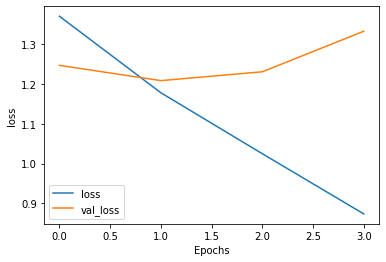

In [21]:
plot_graphs(history, 'loss')

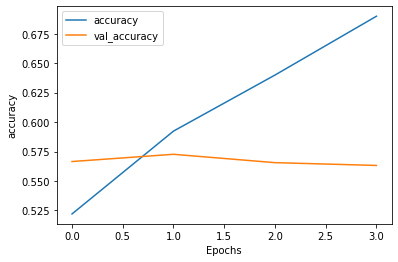

In [22]:
plot_graphs(history, 'accuracy')

In [23]:
# Loss, Accuracy 시각화 함수 2
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

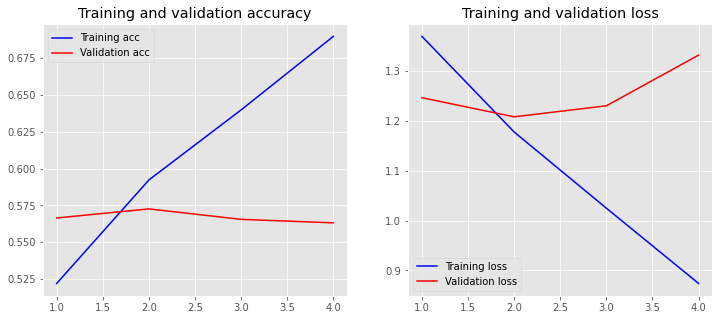

In [24]:
plot_history(history)

# 모델 평가 - 검증 데이터셋(Original Test Dataset)

In [25]:
SAVE_FILE_NM = 'weights_bert_tf2_friends.h5' #저장된 best model 이름
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [26]:
len(dev_df)

1178

In [27]:
input_ids = []
attention_masks = []
token_type_ids = []
dev_data_labels = []

for dev_sent, dev_label in tqdm(zip(dev_df["utterance"], dev_df["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(dev_sent, MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        dev_data_labels.append(dev_label)
    except Exception as e:
        print(e)
        print(dev_sent)
        pass

dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)

dev_data_labels = np.asarray(dev_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(dev_input_ids), len(dev_data_labels)))

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
1178it [00:00, 5538.38it/s]

num sents, labels 1178, 1178


In [28]:
# optimizer='sgd'
# optimizer='adam'
# optimizer='rmsprop'
# optimizer=optimizers.RMSprop(lr=0.001)
# optimizer=tf.keras.optimizers.Adam(3e-5) => dev loss, dev acc:  [1.1843535900115967, 0.579956591129303]

results = model.evaluate(dev_inputs, dev_data_labels, batch_size=1024)
print("dev loss, dev acc: ", results)


2/2 [==============================] - 0s 121ms/step - loss: 1.3016 - accuracy: 0.5713
dev loss, dev acc:  [1.3015730381011963, 0.5713073015213013]


### F1-Score 확인

In [29]:
preds = model.predict(dev_inputs)

dev_preds = []
for i, pred in enumerate(preds):
    result = np.argmax(pred)
    dev_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, dev_preds[i])

0번 인덱스 데이터 처리 완료 => [ 0.85405886 -1.0320783  -0.03442011 -0.33239543 -0.7723017  -0.6694143
  1.4089861  -0.85004795] 6
1번 인덱스 데이터 처리 완료 => [ 0.36351278  2.4855208  -2.5575056  -2.2893994  -1.0086625  -1.6093469
  3.5650396  -1.6515169 ] 6
2번 인덱스 데이터 처리 완료 => [ 1.1071532   1.8430007   0.5362797  -1.7927132  -0.9174581  -0.04412315
 -0.39915198 -0.8881549 ] 1
3번 인덱스 데이터 처리 완료 => [ 1.1504647  -0.89139396  3.7105472  -1.2663528  -1.8727212  -0.8066333
 -0.04899166 -1.4581084 ] 2
4번 인덱스 데이터 처리 완료 => [ 0.76496893 -1.1364465  -0.45058504 -0.5514437  -0.5417926  -0.67015904
  1.3645442  -0.46070215] 6
5번 인덱스 데이터 처리 완료 => [ 0.6420326   3.9149196  -1.823315   -0.03844645 -0.7784282  -2.0095623
 -0.64186776 -1.4197868 ] 1
6번 인덱스 데이터 처리 완료 => [-0.0671801   4.8849545  -1.110968   -0.24405418 -0.7777282  -2.8761196
 -1.1248817  -0.9592083 ] 1
7번 인덱스 데이터 처리 완료 => [ 1.3118628  0.7947969  1.5055456 -1.507597  -1.3363796 -2.0058918
  1.6798722 -1.7833236] 6
8번 인덱스 데이터 처리 완료 => [ 1.3130599   0.98731625 

  1.0904757  -0.80266935] 6
534번 인덱스 데이터 처리 완료 => [ 1.0662969   2.1915584  -0.9773884  -0.1558589  -0.20757788 -1.1408017
 -0.87644494 -0.34342322] 1
535번 인덱스 데이터 처리 완료 => [ 1.2936846  -0.06641977 -0.30166057 -0.7412128   0.01285455  1.6657307
 -0.8603124   0.30274612] 5
536번 인덱스 데이터 처리 완료 => [-0.10472999  4.9221106  -0.85775626 -0.18117003 -0.79508734 -2.7213328
 -1.4721038  -0.5783246 ] 1
537번 인덱스 데이터 처리 완료 => [ 1.0688959   0.34553558 -1.3523831   0.99879616  0.53926545 -0.38594258
 -0.51898676 -0.31872597] 0
538번 인덱스 데이터 처리 완료 => [ 1.2670559  2.8456564 -1.7850692 -1.490376  -1.0322584 -1.2375429
  0.5356208 -0.9977923] 1
539번 인덱스 데이터 처리 완료 => [ 1.0092037  -1.1249537   0.5479997  -2.4189122  -1.1064326  -0.17193715
  2.3571317  -1.1609279 ] 6
540번 인덱스 데이터 처리 완료 => [ 1.3599931  -1.3950655  -1.3622026  -0.7287611  -0.03672786  1.3427033
  1.4145296  -0.07728992] 6
541번 인덱스 데이터 처리 완료 => [ 1.6029236  -1.3712962   0.38706532 -1.1037214  -0.8859995   1.899579
  0.45308584  0.27836284] 5
54

1111번 인덱스 데이터 처리 완료 => [ 0.73937047  3.1214018  -1.917388   -1.8589717  -1.5009149  -1.7304446
  1.7031754  -1.1294974 ] 1
1112번 인덱스 데이터 처리 완료 => [ 1.0124509   2.180252   -1.4488726  -0.2645994  -0.10726614 -0.6975884
 -0.5701798  -0.10289787] 1
1113번 인덱스 데이터 처리 완료 => [ 1.4037609   0.7115649   1.1766044  -1.7861011  -1.3040534  -0.23812158
  0.39242238 -1.1294181 ] 0
1114번 인덱스 데이터 처리 완료 => [ 1.0669585   1.2886108  -1.5212871  -0.10155304 -0.16033413 -0.8480172
  0.5509764  -0.70921147] 1
1115번 인덱스 데이터 처리 완료 => [ 0.91476697  4.1509914  -0.41523382  0.42999348 -0.9452752  -2.1742358
 -0.90149015 -1.1988682 ] 1
1116번 인덱스 데이터 처리 완료 => [ 1.2979575   0.5935432  -1.0675797  -1.1988139  -0.7298356  -0.33832577
  1.4285096  -0.57477576] 6
1117번 인덱스 데이터 처리 완료 => [ 0.6836754  2.8854854 -2.3915389 -1.9145367 -1.385428  -1.8049924
  2.588188  -1.8618985] 1
1118번 인덱스 데이터 처리 완료 => [ 1.0768716   0.19752145 -0.8577831  -2.261213   -0.73072374  0.4662015
  1.7883576  -0.943764  ] 6
1119번 인덱스 데이터 처리 완료 =

In [30]:
dev_preds[:5]

[6, 6, 1, 2, 6]

In [31]:
from sklearn.metrics import f1_score
f1 = f1_score(dev_data_labels, dev_preds, average='weighted')
print('F1 Score : {:.5f}'.format(f1))

F1 Score : 0.51832


# (참고) 제출 파일 생성

In [36]:
input_ids = []
attention_masks = []
token_type_ids = []

for test_sent in tqdm(test_df["utterance"]):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)

print("num sents {}".format(len(test_input_ids)))

100%|██████████| 1623/1623 [00:00<00:00, 5415.02it/s]

num sents 1623


In [37]:
start = time.time()

preds = model.predict(test_inputs)

test_preds = []
for i, pred in enumerate(preds):
    result = np.argmax(pred)
    test_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, test_preds[i])

print("time : ", time.time() - start)

0번 인덱스 데이터 처리 완료 => [ 1.2106503  2.8076353 -0.6037066 -2.718342  -1.6542073 -1.5412824
  1.2867231 -1.7914919] 1
1번 인덱스 데이터 처리 완료 => [ 1.5641372  -0.61096174  2.5381522  -3.0496707  -2.0959358  -0.50457746
  2.0352674  -1.6578071 ] 2
2번 인덱스 데이터 처리 완료 => [ 1.6954422  -0.92568916  0.9411713  -2.711739   -1.1418183   1.6668164
  1.0909258  -0.8721662 ] 0
3번 인덱스 데이터 처리 완료 => [ 1.0359007   4.4235883  -0.7544321  -1.1742231  -1.549826   -1.302703
 -0.85882056 -1.4143399 ] 1
4번 인덱스 데이터 처리 완료 => [ 1.6582743  -0.93263644  0.7389642  -2.5565329  -0.82522815  1.4844391
  1.1420285  -0.8041065 ] 0
5번 인덱스 데이터 처리 완료 => [ 1.6731917   0.94102186 -1.0920116   0.11294191 -0.89544255 -1.1904297
  0.22084852 -0.9024137 ] 0
6번 인덱스 데이터 처리 완료 => [ 1.241029    2.4235675   0.00490679 -0.1713976  -1.5077955  -1.2376554
 -1.0067607  -0.82167304] 1
7번 인덱스 데이터 처리 완료 => [ 1.2888749   1.4254284  -1.4269408  -0.326164   -0.50809747 -0.740129
  0.06453331 -0.77608764] 1
8번 인덱스 데이터 처리 완료 => [ 1.3548647   1.2362418  -0.

  2.821832  -1.5028365] 6
526번 인덱스 데이터 처리 완료 => [ 1.5050023  -0.60398275  1.6245548  -2.4897091  -1.3991241  -0.16629215
  1.8346225  -1.2072413 ] 6
527번 인덱스 데이터 처리 완료 => [ 1.2682314   2.7094998  -0.79653823 -0.94034344 -1.2635752  -0.95351654
 -0.30455592 -0.81452256] 1
528번 인덱스 데이터 처리 완료 => [ 1.1554189   3.3730733   0.03719762 -1.5742375  -2.0611405  -1.7636663
 -0.35317722 -1.4314578 ] 1
529번 인덱스 데이터 처리 완료 => [ 1.0860049   3.422366    0.6990013  -1.2147185  -1.7862426  -1.8839062
 -0.90110135 -1.4917308 ] 1
530번 인덱스 데이터 처리 완료 => [ 1.2023953   2.35101     0.41801396 -2.7460191  -2.0714035  -1.6689668
  1.7204976  -1.5212449 ] 1
531번 인덱스 데이터 처리 완료 => [ 1.4288348   1.4658855   0.35320672 -0.17047182 -1.5526546  -1.5632287
 -0.5912485  -0.7647643 ] 1
532번 인덱스 데이터 처리 완료 => [ 0.91066444  4.2907577   0.03417934 -0.698336   -1.1588314  -1.341186
 -2.0216098  -1.2291771 ] 1
533번 인덱스 데이터 처리 완료 => [ 0.90525556  4.402949   -0.27033755 -1.1267474  -1.5631359  -1.3665695
 -1.0445834  -1.8463159 ]

 -0.5309977  -0.68453133] 1
1055번 인덱스 데이터 처리 완료 => [ 1.7903599   1.1097087   0.945908   -1.2224759  -1.6861537  -1.1913162
 -0.12394907 -0.14810595] 0
1056번 인덱스 데이터 처리 완료 => [ 1.7424389   1.7405576  -0.72455794 -0.5015386  -0.8228572  -0.8632218
 -0.2717294  -0.964626  ] 0
1057번 인덱스 데이터 처리 완료 => [ 1.7602955   1.4410108  -0.8777987  -0.16702792 -0.59843796 -0.610498
 -0.1942015  -0.43040794] 0
1058번 인덱스 데이터 처리 완료 => [ 1.4163195   1.3833892  -1.056842    0.32494608 -0.08783467 -0.29716644
 -0.7641851  -0.7028837 ] 0
1059번 인덱스 데이터 처리 완료 => [ 1.4512589   1.0434259  -1.5024818   0.22759795 -0.25759044 -1.1191181
  0.17457506 -0.8508945 ] 0
1060번 인덱스 데이터 처리 완료 => [ 0.81780815  4.2105584   0.111549   -1.2860496  -1.5142006  -1.4328681
 -1.3587676  -1.3919009 ] 1
1061번 인덱스 데이터 처리 완료 => [ 1.3076227   2.4033456  -0.32285264 -0.9050533  -1.120696   -1.1432322
 -0.75610995 -0.7903765 ] 1
1062번 인덱스 데이터 처리 완료 => [ 1.4118595  2.1161504 -1.4768413 -2.5279589 -1.5606036 -1.0175422
  2.3555799 -1.573270

 -0.70443153 -1.1563599 ] 1
1609번 인덱스 데이터 처리 완료 => [ 1.1687975  3.9051013 -0.3400103 -1.4226884 -1.8996294 -1.5717396
 -0.650723  -1.5782152] 1
1610번 인덱스 데이터 처리 완료 => [ 1.2782063   2.6921153  -0.6696817  -1.3658423  -1.4840733  -1.2649907
 -0.11588943 -0.9149922 ] 1
1611번 인덱스 데이터 처리 완료 => [ 1.2602074  1.7898364 -1.3126651 -2.798972  -1.5922    -0.881845
  2.7364118 -1.6565582] 6
1612번 인덱스 데이터 처리 완료 => [ 1.318501    1.83358    -0.54332435  0.7317774  -1.1390961  -1.4790958
 -0.61679506 -0.9606809 ] 1
1613번 인덱스 데이터 처리 완료 => [ 1.6847497   1.232593   -1.3219613  -1.1332129  -0.5276628  -0.25250825
  0.75909233 -0.94272685] 0
1614번 인덱스 데이터 처리 완료 => [ 1.9435567  -0.05987134 -0.0486346  -1.2739135  -1.2629703  -0.80573124
  1.2805787  -1.0097989 ] 0
1615번 인덱스 데이터 처리 완료 => [ 1.5061212   1.1058915  -1.2431481   0.7595383  -0.31782305 -1.6115168
 -0.33197132 -0.5439805 ] 0
1616번 인덱스 데이터 처리 완료 => [ 1.43674    1.7541453 -1.0817862 -2.363159  -1.6978308 -1.0963818
  2.483705  -1.3200026] 6
1617번 인덱

In [38]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

# 테스트 데이터의 id, 리뷰 부분을 리스트 처리
ids = list(test_df['id'])
test_utterances = list(test_df['utterance'])

# 숫자로 인코딩 된 레이블을 감정명으로 재매칭
emo_preds = [emoset_reverse[label] for label in test_preds]

# 판다스 데이터프레임 통해 데이터 구성하여 output에 투입
output = pd.DataFrame( data={"Id": ids, "Predicted": emo_preds} )
output.head()

,Id,Predicted
0,0,neutral
1,1,joy
2,2,non-neutral
3,3,neutral
4,4,non-neutral


In [39]:
# 해당 경로가 없으면 생성
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

SAVE_NM = "FRIENDS_BERT_Tensorflow_MAXLN"+str(MAX_LEN)+"_BATSZ"+str(BATCH_SIZE)+"_EPOCH"+str(NUM_EPOCHS)+".csv"
    
# csv파일로 만든다
output.to_csv(DATA_OUT_PATH + SAVE_NM, index = False)  # 앙상블 조합 및 캐글 용도

### 캐글 제출 결과
**[2020.12.18]**<br>
FRIENDS_BERT_Tensorflow_MAXLN64_BATSZ32_EPOCH5 => 0.51294
FRIENDS_BERT_Tensorflow_MAXLN64_BATSZ64_EPOCH5 => 0.53760

**[2020.12.20]**<br>
FRIENDS_BERT_Tensorflow_MAXLN64_BATSZ64_EPOCH5 => 0.53637

# (참고) 입력 문장 감정 예측하기

In [57]:
sentences = ['how do you know?', 'I love you!', 'I hate that!']

In [58]:
input_ids = []
attention_masks = []
token_type_ids = []

for sen_sent in tqdm(sentences):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(sen_sent, MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sen_sent)
        pass

sen_input_ids = np.array(input_ids, dtype=int)
sen_attention_masks = np.array(attention_masks, dtype=int)
sen_type_ids = np.array(token_type_ids, dtype=int)
sen_inputs = (sen_input_ids, sen_attention_masks, sen_type_ids)

print("num sents {}".format(len(sen_input_ids)))

100%|██████████| 3/3 [00:00<00:00, 7480.92it/s]

num sents 3


In [59]:
sen_preds = []
for i, pred in enumerate(preds):
    result = np.argmax(pred)
    sen_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, sen_preds[i])

0번 인덱스 데이터 처리 완료 => [ 1.2271687  2.776075  -0.5968902 -2.722253  -1.6513716 -1.552108
  1.310914  -1.815671 ] 1
1번 인덱스 데이터 처리 완료 => [ 1.57461    -0.60850847  2.5594177  -3.0455275  -2.0988932  -0.5199947
  2.0283723  -1.6579893 ] 2
2번 인덱스 데이터 처리 완료 => [ 1.7049397 -0.9194993  0.9562323 -2.7119954 -1.1481066  1.638712
  1.0950146 -0.8797352] 0
3번 인덱스 데이터 처리 완료 => [ 1.0396194   4.434833   -0.7429395  -1.1670403  -1.5551677  -1.306926
 -0.88408685 -1.4168439 ] 1
4번 인덱스 데이터 처리 완료 => [ 1.6673172 -0.9130157  0.7845614 -2.5619514 -0.8462429  1.4461242
  1.1382415 -0.8237612] 0
5번 인덱스 데이터 처리 완료 => [ 1.6979669   0.96215224 -1.0456734   0.09307831 -0.9167671  -1.1895665
  0.19758055 -0.9251635 ] 0
6번 인덱스 데이터 처리 완료 => [ 1.24297512e+00  2.37944102e+00  2.18021288e-03 -1.18636996e-01
 -1.51255310e+00 -1.26448679e+00 -9.95772839e-01 -8.07114601e-01] 1
7번 인덱스 데이터 처리 완료 => [ 1.2942843   1.4327476  -1.4195465  -0.3394376  -0.5132192  -0.74269617
  0.05161065 -0.78711694] 1
8번 인덱스 데이터 처리 완료 => [ 1.353687

563번 인덱스 데이터 처리 완료 => [ 1.7910734  -0.3209627   1.6393421  -2.9976277  -2.0101614  -0.20201908
  1.9940741  -1.5394193 ] 6
564번 인덱스 데이터 처리 완료 => [ 1.8534256   0.55818903  2.0106285  -1.745072   -2.087905   -1.4924887
  0.30595526 -1.2996302 ] 2
565번 인덱스 데이터 처리 완료 => [ 1.8800675   0.9346138  -1.3719782  -0.7752328  -0.584369   -0.25471345
  0.79366624 -0.95523626] 0
566번 인덱스 데이터 처리 완료 => [ 1.4555136   1.0133954   3.8216212  -2.2098334  -2.1425238  -1.3623368
 -0.03651664 -1.9285337 ] 2
567번 인덱스 데이터 처리 완료 => [ 0.9456118  -1.9931142  -0.02544004 -2.7670033  -1.2668933   0.08544783
  4.0987988  -0.43786332] 6
568번 인덱스 데이터 처리 완료 => [ 0.31631175  5.244595   -0.23250802 -0.73475385 -1.5711564  -1.5224494
 -2.0506012  -1.50713   ] 1
569번 인덱스 데이터 처리 완료 => [ 1.4971882  -0.02300818  3.7811353  -2.2798219  -2.0070453  -1.2004963
  0.6768376  -2.1584303 ] 2
570번 인덱스 데이터 처리 완료 => [ 1.5292109   2.220958   -0.40494913 -1.3213247  -1.3591641  -1.033429
  0.08460574 -1.5379457 ] 1
571번 인덱스 데이터 처리 완료 => 

680번 인덱스 데이터 처리 완료 => [ 1.6968759 -1.5923315  0.4144063 -2.528494  -1.1224933  1.0228776
  2.6682022 -1.0664048] 6
681번 인덱스 데이터 처리 완료 => [ 1.6954683  -0.68082905  2.2856958  -2.7481823  -1.6489264   0.505714
  1.5797043  -1.5131761 ] 2
682번 인덱스 데이터 처리 완료 => [ 1.5553019  -0.6457535  -0.13880806 -2.6340358  -1.44687     0.02265127
  3.0959742  -1.2236989 ] 6
683번 인덱스 데이터 처리 완료 => [ 0.9768702  1.75459   -1.8942512 -2.8587208 -1.5697584 -0.8599401
  3.5848098 -1.40585  ] 6
684번 인덱스 데이터 처리 완료 => [ 1.5706129  -1.2415423   1.3174003  -3.1161313  -1.5796869   0.69166154
  2.578856   -0.9704766 ] 6
685번 인덱스 데이터 처리 완료 => [ 0.53624415 -2.0304496  -0.09078246 -2.5640833  -1.0513715  -0.3815166
  4.163745   -0.4330487 ] 6
686번 인덱스 데이터 처리 완료 => [ 1.452902   -0.7759171   1.1644337  -3.1637743  -1.888239    0.04688703
  2.4904456  -1.2644848 ] 6
687번 인덱스 데이터 처리 완료 => [ 1.5807174   0.9049144  -0.7202557   0.4496346  -0.38254142 -0.93182576
 -0.5830953  -0.8986311 ] 0
688번 인덱스 데이터 처리 완료 => [ 1.9313375  

  0.8161216  -1.0137818 ] 0
773번 인덱스 데이터 처리 완료 => [ 1.3533404   2.3386762  -1.7683231  -2.3103957  -1.5978955  -0.78874344
  2.3357468  -1.8708345 ] 1
774번 인덱스 데이터 처리 완료 => [ 1.7173988  -0.59854     0.20879585 -2.736861   -1.1576294   0.9637986
  2.0157402  -0.94077665] 6
775번 인덱스 데이터 처리 완료 => [ 1.4613663 -0.7910428  1.0209028 -2.8417675 -1.249204   1.207478
  1.0019051 -0.6995992] 0
776번 인덱스 데이터 처리 완료 => [ 1.5221425   1.93791     0.5406219  -0.89731747 -1.6163267  -1.4917842
 -0.15911856 -1.2793697 ] 1
777번 인덱스 데이터 처리 완료 => [ 1.1892946  -1.717682   -0.98487496 -2.12285    -0.64102787  0.49660167
  3.4398606  -0.28926566] 6
778번 인덱스 데이터 처리 완료 => [ 1.0012269   2.2224824   0.15012912 -0.51837045 -0.5118727  -0.5751336
 -1.9544282  -0.49314886] 1
779번 인덱스 데이터 처리 완료 => [ 1.5960027  -0.9438438   0.44465005 -2.440221   -1.3780164  -0.12274852
  2.408259   -1.0470177 ] 6
780번 인덱스 데이터 처리 완료 => [ 1.1950111   2.2677672   0.10801563 -0.63878316 -0.79077804 -0.6446415
 -1.4034752  -0.19994286] 1
7

  4.249039   -0.35926324] 6
1115번 인덱스 데이터 처리 완료 => [ 1.472558   2.2718923 -1.1439449 -2.5310903 -1.7215401 -0.7757817
  1.9254642 -1.5481861] 1
1116번 인덱스 데이터 처리 완료 => [ 1.792056    1.5644192  -0.26267695  0.09519766 -0.8406538  -1.2276702
 -0.9917427  -0.58945626] 0
1117번 인덱스 데이터 처리 완료 => [ 1.8336174  -1.4935231   0.61268204 -1.6239601  -1.2054583   0.38953692
  1.8189967  -0.6455891 ] 0
1118번 인덱스 데이터 처리 완료 => [ 1.2202951   3.1116793  -0.8282981  -0.23410185 -1.0162418  -1.0423065
 -1.1003511  -1.3316039 ] 1
1119번 인덱스 데이터 처리 완료 => [ 0.55250734  4.602918   -0.53422785 -0.18417606 -1.3835713  -1.8273388
 -2.2478216  -1.245186  ] 1
1120번 인덱스 데이터 처리 완료 => [ 1.0382745  3.7837236 -0.86326   -2.5584497 -1.9700382 -1.590746
  1.5418248 -1.9957099] 1
1121번 인덱스 데이터 처리 완료 => [ 1.2167209   3.6171846  -0.42706552 -1.5128024  -1.2542523  -1.2373713
 -0.4374646  -1.2750903 ] 1
1122번 인덱스 데이터 처리 완료 => [ 1.2311274  2.5300481 -1.9368907 -1.9270709 -1.3552723 -0.8093476
  1.8548275 -1.5546719] 1
1123번 인덱스

 -0.7011594 -0.9634746] 1
1226번 인덱스 데이터 처리 완료 => [ 1.2335042  2.7960863  0.542309  -1.141465  -1.3800772 -1.55384
 -0.7176898 -0.9037798] 1
1227번 인덱스 데이터 처리 완료 => [ 1.6638511  -0.60237575  2.8189814  -2.917945   -1.7907571   0.07735626
  1.2303457  -1.5880948 ] 2
1228번 인덱스 데이터 처리 완료 => [ 1.1374807   0.85061383  0.32841423  1.6102246  -0.83962107 -1.7773623
 -1.2321583  -1.0961362 ] 3
1229번 인덱스 데이터 처리 완료 => [ 1.6305391   2.841363    0.70207465 -1.5655565  -1.7154846  -1.5450126
 -0.3649897  -1.4167042 ] 1
1230번 인덱스 데이터 처리 완료 => [ 0.9915653   2.683274    0.18173872 -0.92541975 -0.82819074 -1.2267853
 -1.1175697  -0.68741983] 1
1231번 인덱스 데이터 처리 완료 => [ 0.41270632  5.1301713   0.2663811  -0.58921486 -1.4745797  -1.7491661
 -2.0095398  -1.2577252 ] 1
1232번 인덱스 데이터 처리 완료 => [ 1.5438783   1.24477     0.40296122 -2.5156     -1.9604583  -1.2338241
  1.9838227  -1.3147169 ] 6
1233번 인덱스 데이터 처리 완료 => [ 1.7692827  -1.3402164   0.7839362  -2.239519   -0.83641624  1.7986225
  1.0126401  -0.6430555 ] 

  0.03597007 -1.7518624 ] 0
1318번 인덱스 데이터 처리 완료 => [ 1.4098213   0.6316359  -1.641951   -2.1102588  -0.9638829  -0.31561223
  2.6349828  -1.080069  ] 6
1319번 인덱스 데이터 처리 완료 => [ 1.1523694   2.6191473  -0.02287268 -0.8316161  -0.7606199  -0.9763742
 -1.2024201  -0.70919764] 1
1320번 인덱스 데이터 처리 완료 => [ 1.6901966  -0.74027693 -0.5096204  -2.3047333  -0.6393698   1.5573908
  1.678084   -1.0921389 ] 0
1321번 인덱스 데이터 처리 완료 => [ 1.7608589  -0.49479935  2.8539736  -2.753601   -1.8463262   0.12207912
  1.1761837  -1.8276181 ] 2
1322번 인덱스 데이터 처리 완료 => [ 1.5812527  -0.72479963 -0.6761492  -2.213892   -0.54022974  2.0702493
  1.2589401  -0.7009353 ] 5
1323번 인덱스 데이터 처리 완료 => [ 0.82645595  3.7030463  -1.620193   -2.109732   -1.518813   -1.2738857
  1.1548003  -2.0249956 ] 1
1324번 인덱스 데이터 처리 완료 => [ 1.2671745   2.2599432  -0.42589045 -0.7149826  -1.1212095  -1.1851116
 -0.8935942  -0.3693456 ] 1
1325번 인덱스 데이터 처리 완료 => [ 0.9176095   0.84755033 -0.93276334  1.5753509   0.1344946  -1.4744809
 -1.3755095  -

In [60]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

preds = model.predict(sen_inputs)

sen_preds = []

for i, pred in enumerate(preds):
    result = np.argmax(pred)
    sen_preds.append(result)
    print('['+str(i+1)+'번 문장]\n'+'예측: %s\n' %\
          (emoset_reverse[sen_preds[i]]))

[1번 문장]
예측: neutral

[2번 문장]
예측: joy

[3번 문장]
예측: non-neutral



---